In [ ]:
%load_ext autoreload
%autoreload 2

#https://mc-stan.org/docs/2_18/stan-users-guide/bayesian-measurement-error-model.html

In [2]:
# add noise to prediction

In [3]:
#from mdm.dataset import Standardization, LogTransform
RANDOM_SEED=1985

In [4]:
import pandas as pd
import pymc3 as pm

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import theano.tensor as tt

In [5]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/green_channel.csv")
df = pd.read_csv("../data/co_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

In [6]:
def tt_standardize(x, x_o=None):
    if x_o is None:
        x_o = x
        
    x_std = (x - tt.mean(x_o)) / tt.std(x_o)
    return x_std


def tt_unstandardize(x_std, x_o):
    #import pdb; pdb.set_trace()    
    x = x_std * tt.std(x_o) + tt.mean(x_o)
    return x

def unstandardize(x_std, x_o):
    #import pdb; pdb.set_trace()    
    x = x_std * np.std(x_o) + np.mean(x_o)
    return x




def tt_log_standardize(x, x_o=None):
    if x_o is None:
        x_o = x
    
    log_x = tt.log(x)
    log_x_o = tt.log(x_o)
    x_std = (log_x - tt.mean(log_x_o)) / (tt.std(log_x_o))
    return x_std
    

def tt_log_unstandardize(x_std, x_o):

    log_x_o = tt.log(x_o) #observed
    log_x = x_std * tt.std(log_x_o) + tt.mean(log_x_o)
    return tt.exp(log_x)
    
def tt_standardize_stage(x, offset, x_o=None):
    if x_o is None:
        x_o = x
    
    log_x = tt.log(x) - offset
    log_x_o = tt.log(x_o) - offset
    x_std = (log_x - tt.mean(log_x_o)) / (tt.std(log_x_o))
    return x_std

def tt_unstandardize_stage(x_std, offset, x_o):

    log_x_o = tt.log(x_o) - offset #observed
    log_x = x_std * tt.std(log_x_o) + tt.mean(log_x_o)
    return tt.exp(log_x + offset)

# plotting?
def predictive_plot(ppc, q_obs, s_obs, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    
    s_obs.min()
    s_min = np.floor(s_obs.min())
    s_max = np.ceil(s_obs.max())
    s_sim = np.linspace(s_min, s_max)
    
    predictor_scaled = tt_log_standardize(s_sim, s_obs).eval()
    q_pred = tt_log_unstandardize(ppc['q_log'], df['q']).eval()
    
    log_mu_ppq = (ppc["a"] + ppc["b"] * predictor_scaled[:, None]).T
    
    log_pred_ppq = (ppc["a"] + ppc["b"] * predictor_scaled[:, None] + ppc['sigma'] * pm.Normal.dist(0,1).random(size=2000)).T
    
    mu_ppq = tt_log_unstandardize(log_mu_ppq, q_obs).eval()
    pred_ppq = tt_log_unstandardize(log_pred_ppq, q_obs).eval()
    
    
    
    #plt.plot(df['stage'], df['q'], "o", ms=4, alpha=0.4, label="Data", color='k')
    
    ax.errorbar(df['stage'],  df['q'], yerr=1.96*df['q_sigma'], fmt='.k');
    
    ax.plot(s_sim, mu_ppq.mean(0), label="Mean outcome", alpha=0.6)
    
    
    az.plot_hdi(
        s_sim,
        pred_ppq,
        ax=ax,
        fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Predictive 94% HPD"},
    )
    
    
    ax.set_xlabel("Stage (feet)")
    ax.set_ylabel("Discharge (ft3/s)")
    
    ax.legend(ncol=2, fontsize=10)

In [7]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/green_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [8]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true, x_o=s_obs)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)

In [9]:
offset_model = pm.Model()

# assume measurement error
with offset_model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true-1.85, x_o=q_obs-1.85)
    s_std = tt_log_standardize(s_true, x_o=s_obs)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)
    
    offset_trace = pm.sample(500, return_inferencedata=False)
    
    
df_comp_loo = az.compare({"simple_error": error_trace, "offset": offset_trace}, ic='loo')
df_comp_loo

In [10]:
with error_model:
    error_trace = pm.sample(500, return_inferencedata=False)
    
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 43 seconds.


NameError: name 'RANDOM_SEED' is not defined

C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


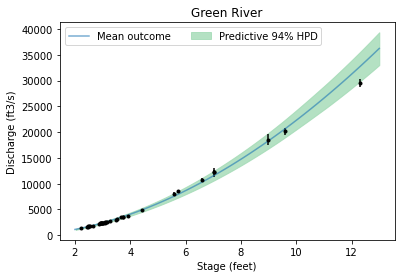

In [683]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Green River")
fig.savefig("../figures/green_channel.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Green River")
#fig.savefig("../figures/green_channel.pdf")

In [731]:
output = pd.DataFrame() 

In [732]:
#site = 'Green River'
#a = ppc['a'].mean()
#b = ppc['b'].mean()
#sigma = ppc['sigma'].mean()
#gerr = np.exp(sigma*1.96)
#
#results = pd.Series({'a':a,'b':b,'gerr':gerr}, name='Green River')
#output = output.append(results)

In [734]:
site = 'Green River'

s_y = np.log(q_obs).std()
s_x = np.log(s_obs).std()
conv = s_y/s_x

a= ppc['a'].mean()
sigma = ppc['sigma'].mean() 
b= ppc['b'].mean() 
sigma = ppc['sigma'].mean()

log_q = np.log(q_obs)
log_s = np.log(s_obs)
a_s = log_q.std()*(a-b*log_s.mean()/log_s.std())+log_q.mean()
b_s = b*log_q.std()/log_s.std()
sigma_s = log_q.std()*sigma
gerr95 = np.exp(sigma_s)**1.96

results = pd.Series({'a':a_s,'b':b_s, 'sigma':sigma_s, 'gerr95':gerr95}, name='Green River')
output = output.append(results)

In [736]:
sigma_s

0.041786376065254933

In [737]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/co_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [738]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=1, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true, x_o=s_obs)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)

In [739]:
with error_model:
    error_trace = pm.sample(500, return_inferencedata=False)
    
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 41 seconds.


C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


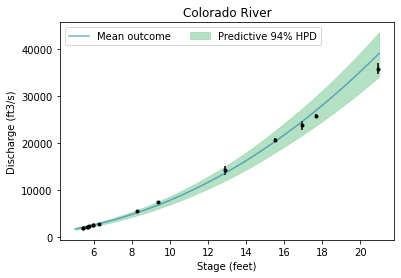

In [740]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Colorado River")
fig.savefig("../figures/co_channel.pdf")

In [741]:
site = 'Colorado River'

s_y = np.log(q_obs).std()
s_x = np.log(s_obs).std()
conv = s_y/s_x

a= ppc['a'].mean()
sigma = ppc['sigma'].mean() 
b= ppc['b'].mean() 
sigma = ppc['sigma'].mean()

log_q = np.log(q_obs)
log_s = np.log(s_obs)
a_s = log_q.std()*(a-b*log_s.mean()/log_s.std())+log_q.mean()
b_s = b*log_q.std()/log_s.std()
sigma_s = log_q.std()*sigma
gerr95 = np.exp(sigma_s)**1.96

results = pd.Series({'a':a_s,'b':b_s, 'sigma':sigma_s, 'gerr95':gerr95}, name='Green River')
output = output.append(results)

In [742]:

#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/chalk_artificial.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [743]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=1, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true, x_o=s_obs)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)

In [744]:
with error_model:
    error_trace = pm.sample(500, return_inferencedata=False)
    
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 34 seconds.


C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


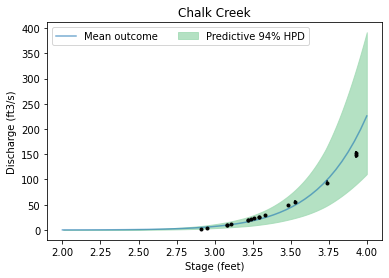

In [745]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Chalk Creek")
fig.savefig("../figures/chalk_artificial.pdf")

In [746]:
site = 'Chalk Creek'

s_y = np.log(q_obs).std()
s_x = np.log(s_obs).std()
conv = s_y/s_x

a= ppc['a'].mean()
sigma = ppc['sigma'].mean() 
b= ppc['b'].mean() 
sigma = ppc['sigma'].mean()

log_q = np.log(q_obs)
log_s = np.log(s_obs)
a_s = log_q.std()*(a-b*log_s.mean()/log_s.std())+log_q.mean()
b_s = b*log_q.std()/log_s.std()
sigma_s = log_q.std()*sigma
gerr95 = np.exp(sigma_s)**1.96

results = pd.Series({'a':a_s,'b':b_s, 'sigma':sigma_s, 'gerr95':gerr95}, name='Green River')
output = output.append(results)

In [51]:

#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/provo_natural.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
q_sigma = q_sigma
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [52]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=1, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true, x_o=s_obs)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)

In [53]:
with error_model:
    error_trace = pm.sample(500, return_inferencedata=False)
    
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 42 seconds.


C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


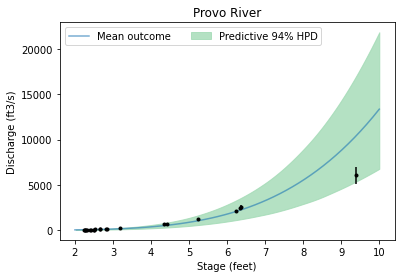

In [54]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Provo River")
fig.savefig("../figures/provo_natural.pdf")

# Scratch

In [ ]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=1, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true, x_o=s_obs)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)

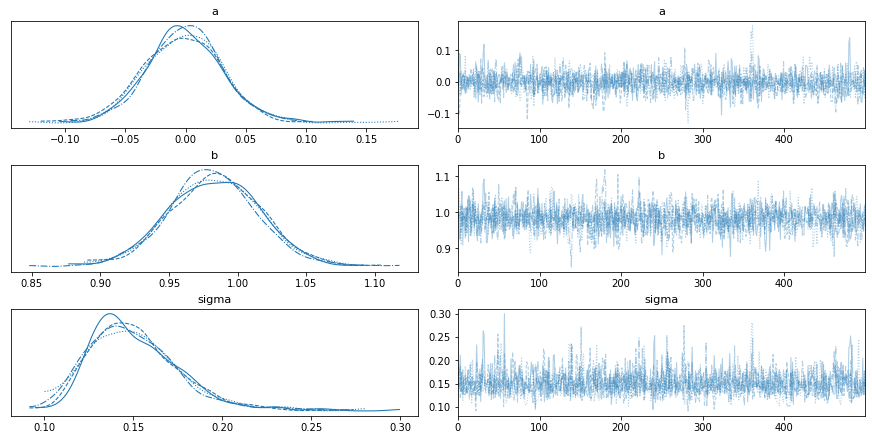

In [55]:
with error_model:
   #offset_trace = pm.sample(500, tune=2000, return_inferencedata=True)
    az.plot_trace(error_trace)

C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0.5, 1.0, 'Provo River offset')

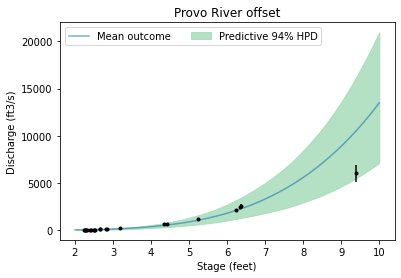

In [45]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Provo River offset")

In [89]:
q_obs.min()

29.5635

In [91]:
offset_model = pm.Model()

# assume measurement error
with offset_model:
    # Priors
    a = pm.Normal("a", mu=0, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    #offset = 1.6
    #offset = pm.HalfNormal('offset',sigma=2)
    #offset = pm.HalfNormal('offset',sigma=2)
    offset = pm.Uniform('offset', 0, 4)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true-offset, x_o=s_obs-offset)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)
    
    offset_trace = pm.sample(500, return_inferencedata=False, target_accept=0.95)
    
    
#df_comp_loo = az.compare({"simple_error": error_trace, "offset": offset_trace}, ic='loo')
#df_comp_loo

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset, sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 48 seconds.


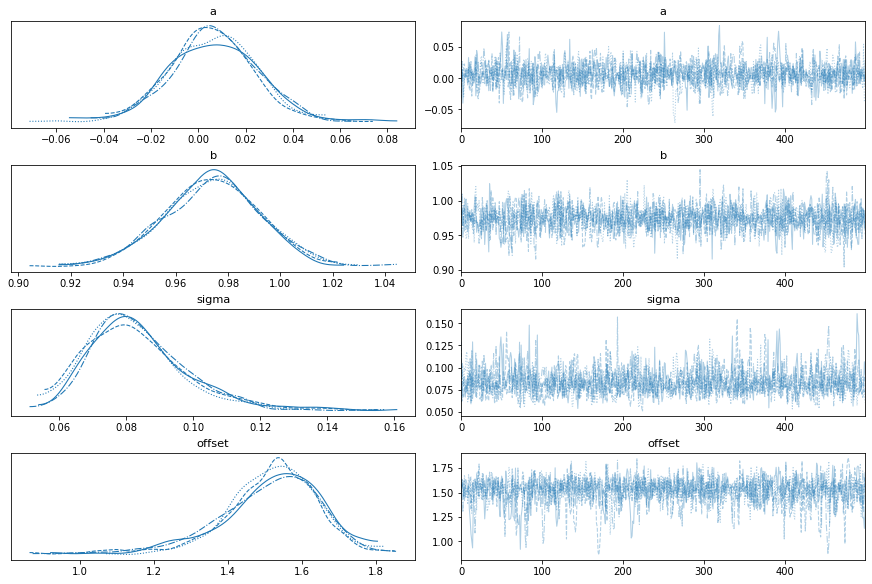

In [92]:
with offset_model:
    #ppc = pm.sample_posterior_predictive(
    #    offset_trace, var_names=["a", "b", "sigma", "offset", "q_log"], random_seed=RANDOM_SEED
    #)
    az.plot_trace(offset_trace)

In [ ]:
with offset_model:
    ppc = pm.sample_posterior_predictive(
        offset_trace, var_names=["a", "b", "sigma", "q_log"], random_seed=RANDOM_SEED
    )
    az.plot_trace(offset_trace)

In [82]:
df_comp_loo = az.compare({"simple_error": error_trace, "offset": offset_trace}, ic='loo')
df_comp_loo

C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly infl

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
offset,0,23.228749,2.557045,0.000000,1.0,3.006601,0.000000,False,log
simple_error,1,8.166056,4.367222,15.062693,0.0,5.015456,5.588603,True,log


In [76]:
import numpy as np
from sklearn.linear_model import LinearRegression

q_log = np.log(df['q'].values.reshape(-1,1))
s_log = np.log(df['stage'].values.reshape(-1,1))
reg = LinearRegression().fit(q_log, s_log)
reg.score(q_log, s_log)


0.9847962140703099

In [78]:
import numpy as np
from sklearn.linear_model import LinearRegression

q_log = np.log(df['q'].values.reshape(-1,1))
s_log = np.log(df['stage'].values.reshape(-1,1) - 1.6)
reg = LinearRegression().fit(q_log, s_log)
reg.score(q_log, s_log)

0.9964388736245303

In [59]:
df_comp_loo = az.compare({"simple_error": error_trace, "offset": offset_trace}, ic='waic')
df_comp_loo


C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without t

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
simple_error,0,8.726761,3.806517,0.000000,1.0,4.522475,0.00000,True,log
offset,1,8.132834,3.596003,0.593927,0.0,4.185189,0.37194,True,log


In [35]:
site = 'Provo River'

s_y = np.log(q_obs).std()
s_x = np.log(s_obs).std()
conv = s_y/s_x

a= ppc['a'].mean()
sigma = ppc['sigma'].mean() 
b= ppc['b'].mean() 
sigma = ppc['sigma'].mean()

log_q = np.log(q_obs)
log_s = np.log(s_obs)
a_s = log_q.std()*(a-b*log_s.mean()/log_s.std())+log_q.mean()
b_s = b*log_q.std()/log_s.std()
sigma_s = log_q.std()*sigma
gerr95 = np.exp(sigma_s)**1.96

results = pd.Series({'a':a_s,'b':b_s, 'sigma':sigma_s, 'gerr95':gerr95}, name='Green River')
output = output.append(results)

NameError: name 'ppc' is not defined

In [752]:
output.to_csv('../simple_rating.csv')

In [753]:
output

,a,b,gerr95,sigma
Green River,5.747832,1.851709,1.085349,0.041786
Green River,3.992859,2.161140,1.113143,0.054687
Green River,-11.364606,12.097564,1.744753,0.283986
Green River,0.343239,3.991411,1.562903,0.227829


In [484]:
#offset model version
offset_model = pm.Model()

# assume measurement error
with offset_model:
    # Priors
    offset = 2.7
    a = pm.Normal("a", mu=1, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    #scaled = tt.log(s_true) - offset
    #s_std = tt_standardize(scaled, tt.log(s_obs))
    s_std = tt_standardize_stage(s_true, offset=offset, x_o=s_obs)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)

In [486]:
with error_model:
    offset_trace = pm.sample(500, return_inferencedata=False)
    
    ppc = pm.sample_posterior_predictive(
        offset_trace, var_names=["a", "b", "sigma", "q_log"], random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 38 seconds.


C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


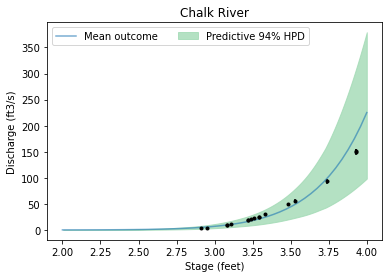

In [487]:
fig, ax = plt.subplots(figsize=(6,4))
predictive_plot(ppc, q_obs, s_obs, ax=ax)
ax.set_title("Chalk River")
fig.savefig("../figures/chalk_artificial.pdf")

In [ ]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=1, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true, x_o=s_obs)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)

In [398]:
error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=1, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    s_std = tt_log_standardize(s_true, x_o=s_obs)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)

In [434]:
with error_model:
    error_trace = pm.sample(500, return_inferencedata=False)
    az.plot_trace(error_trace)

Init signature: pm.Model(*args, **kwargs)
Docstring:     
Encapsulates the variables and likelihood factors of a model.

Model class can be used for creating class based models. To create
a class based model you should inherit from :class:`~.Model` and
override :meth:`~.__init__` with arbitrary definitions (do not
forget to call base class :meth:`__init__` first).

Parameters
----------
name: str
    name that will be used as prefix for names of all random
    variables defined within model
model: Model
    instance of Model that is supposed to be a parent for the new
    instance. If ``None``, context will be used. All variables
    defined within instance will be passed to the parent instance.
    So that 'nested' model contributes to the variables and
    likelihood factors of parent model.
theano_config: dict
    A dictionary of theano config values that should be set
    temporarily in the model context. See the documentation
    of theano for a complete list. Set config key
    `

In [433]:
from pymc3 import Model, Normal

class SimpleModel(Model):
    
    def __init__(self, q_obs, s_obs, q_sigma=0, s_sigma=0):
        super().__init__(name, model)
        self.q_obs = q_obs
        self.s_obs = s_obs
        self.q_sigma = q_sigma
        self.s_sigma = s_sigma
        
        a = pm.Normal("a", mu=1, sigma=1)
        b = pm.Normal("b", mu=0, sigma=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        
        # Observation model
        q_true = self.q_obs + self.q_sigma * pm.Normal.dist(0,1).random(size=n)
        s_true = self.s_obs + self.s_sigma * pm.Normal.dist(0,1).random(size=n)
    
        q_std = tt_log_standardize(q_true, x_o=self.q_obs)
        s_std = tt_log_standardize(s_true, x_o=self.s_obs)
        
        # Process model
        mu = a + b * s_std
        y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)



In [451]:
error_model = SimpleModel(q_obs, s_obs, q_sigma, s_sigma)


In [452]:
with error_model:
    error_trace = pm.sample(500, return_inferencedata=False)
    az.plot_trace(error_trace)

MissingInputError: Input 0 of the graph (indices start from 0), used to compute Elemwise{exp,no_inplace}(sigma_log__), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [388]:
stage_min = np.floor(df['stage'].min())
stage_max = np.ceil(df['stage'].max())
stage_sim = np.linspace(stage_min, stage_max)

In [400]:
with error_model:
    #pm.set_data({"s_shared": stage_sim})
    ppc = pm.sample_posterior_predictive(
        error_trace, var_names=["a", "b", "sigma", "q_log"], random_seed=RANDOM_SEED
        #error_trace#, var_names=["a", "b", "sigma", "q_log"], random_seed=RANDOM_SEED
    )

In [455]:

def predictive_plot(ppc, q_obs, s_obs, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    
    s_obs.min()
    s_min = np.floor(s_obs.min())
    s_max = np.ceil(s_obs.max())
    s_sim = np.linspace(s_min, s_max)
    
    predictor_scaled = tt_log_standardize(s_sim, s_obs).eval()
    q_pred = tt_log_unstandardize(ppc['q_log'], df['q']).eval()
    
    log_mu_ppq = (ppc["a"] + ppc["b"] * predictor_scaled[:, None]).T
    
    log_pred_ppq = (ppc["a"] + ppc["b"] * predictor_scaled[:, None] + ppc['sigma'] * pm.Normal.dist(0,1).random(size=2000)).T
    
    mu_ppq = tt_log_unstandardize(log_mu_ppq, q_obs).eval()
    pred_ppq = tt_log_unstandardize(log_pred_ppq, q_obs).eval()
    
    
    
    #plt.plot(df['stage'], df['q'], "o", ms=4, alpha=0.4, label="Data", color='k')
    
    ax.errorbar(df['stage'],  df['q'], yerr=1.96*df['q_sigma'], fmt='.k');
    
    ax.plot(s_sim, mu_ppq.mean(0), label="Mean outcome", alpha=0.6)
    
    
    az.plot_hdi(
        s_sim,
        pred_ppq,
        ax=ax,
        fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Predictive 94% HPD"},
    )
    
    
    ax.set_xlabel("Stage (feet)")
    ax.set_ylabel("Discharge (ft3/s)")
    ax.set_title("Green")
    ax.legend(ncol=2, fontsize=10)

C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


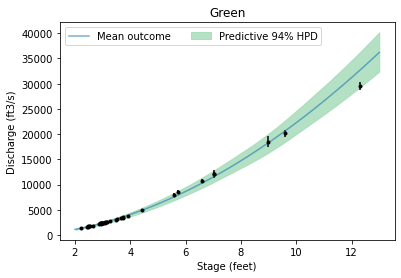

In [456]:
predictive_plot(ppc, q_obs, s_obs)

C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


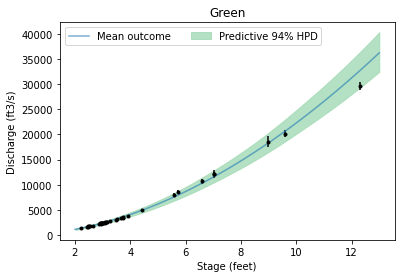

In [415]:


s_obs.min()
s_min = np.floor(s_obs.min())
s_max = np.ceil(s_obs.max())
s_sim = np.linspace(s_min, s_max)

predictor_scaled = tt_log_standardize(s_sim, s_obs).eval()
q_pred = tt_log_unstandardize(ppc['q_log'], df['q']).eval()

log_mu_ppq = (ppc["a"] + ppc["b"] * predictor_scaled[:, None]).T

log_pred_ppq = (ppc["a"] + ppc["b"] * predictor_scaled[:, None] + ppc['sigma'] * pm.Normal.dist(0,1).random(size=2000)).T

mu_ppq = tt_log_unstandardize(log_mu_ppq, q_obs).eval()
pred_ppq = tt_log_unstandardize(log_pred_ppq, q_obs).eval()

_, ax = plt.subplots()

#plt.plot(df['stage'], df['q'], "o", ms=4, alpha=0.4, label="Data", color='k')

ax.errorbar(df['stage'],  df['q'], yerr=1.96*df['q_sigma'], fmt='.k');

ax.plot(s_sim, mu_ppq.mean(0), label="Mean outcome", alpha=0.6)


az.plot_hdi(
    s_sim,
    pred_ppq,
    ax=ax,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Predictive 94% HPD"},
)


ax.set_xlabel("Stage (feet)")
ax.set_ylabel("Discharge (ft3/s)")
ax.set_title("Green")
ax.legend(ncol=2, fontsize=10)

In [417]:
az.plot_hdi?

Signature:
az.plot_hdi(
    x,
    y=None,
    hdi_prob=None,
    hdi_data=None,
    color='C1',
    circular=False,
    smooth=True,
    smooth_kwargs=None,
    figsize=None,
    fill_kwargs=None,
    plot_kwargs=None,
    hdi_kwargs=None,
    ax=None,
    backend=None,
    backend_kwargs=None,
    show=None,
)
Docstring:
Plot HDI intervals for regression data.

Parameters
----------
x : array-like
    Values to plot.
y : array-like, optional
    Values from which to compute the HDI. Assumed shape ``(chain, draw, \*shape)``.
    Only optional if hdi_data is present.
hdi_data : array_like, optional
    Precomputed HDI values to use. Assumed shape is ``(*x.shape, 2)``.
hdi_prob : float, optional
    Probability for the highest density interval. Defaults to ``stats.hdi_prob`` rcParam.
color : str, optional
    Color used for the limits of the HDI and fill. Should be a valid matplotlib color.
circular : bool, optional
    Whether to compute the HDI taking into account `x` is a circular va

In [364]:
q

NameError: name 'q' is not defined

In [289]:
offset_model = pm.Model()

# assume measurement error
with offset_model:
    # Priors
    #offset = 1.85
    a = pm.Normal("a", mu=1, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    
    q_std = tt_log_standardize(q_true, x_o=q_obs)
    #scaled = tt.log(s_true) - offset
    #s_std = tt_standardize(scaled, tt.log(s_obs))
    s_std = tt_standardize_stage(s_true, offset=2.20, x_o=s_obs)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_log", mu=mu, sigma=sigma, observed=q_std)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 2_000 tune and 500 draw iterations (8_000 + 2_000 draws total) took 29 seconds.


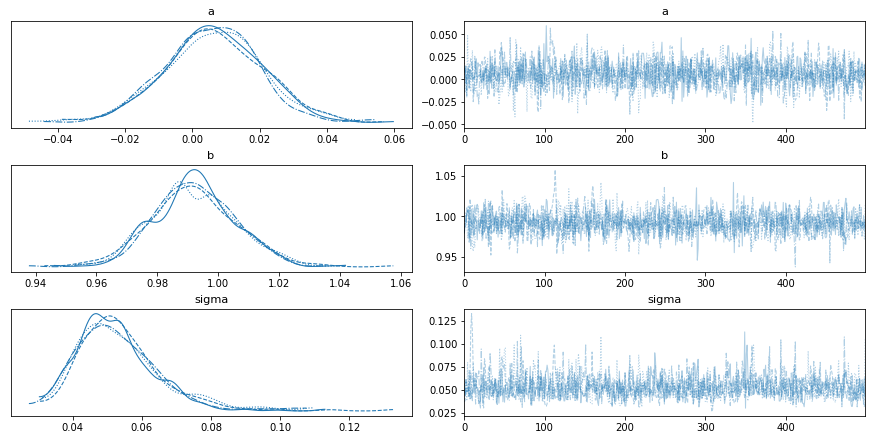

In [290]:
with offset_model:
    offset_trace = pm.sample(500, tune=2000, return_inferencedata=True)
    az.plot_trace(offset_trace)

In [291]:
with offset_model:
    ppc = pm.sample_posterior_predictive(
        offset_trace, var_names=["a", "b", "q_log"], random_seed=RANDOM_SEED
    )

C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


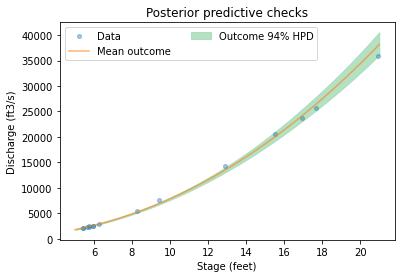

In [292]:
s_obs.min()
s_min = np.floor(s_obs.min())
s_max = np.ceil(s_obs.max())
s_sim = np.linspace(s_min, s_max)

predictor_scaled = tt_standardize_stage(s_sim, 1.85, s_obs).eval()
q_pred = tt_log_unstandardize(ppc['q_log'], df['q']).eval()

log_mu_ppq = (ppc["a"] + ppc["b"] * predictor_scaled[:, None]).T

mu_ppq = tt_log_unstandardize(log_mu_ppq, q_obs).eval()


_, ax = plt.subplots()

ax.plot(df['stage'], df['q'], "o", ms=4, alpha=0.4, label="Data")

ax.plot(s_sim, mu_ppq.mean(0), label="Mean outcome", alpha=0.6)

az.plot_hdi(
    s_sim,
    mu_ppq,
    ax=ax,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Outcome 94% HPD"},
)



ax.set_xlabel("Stage (feet)")
ax.set_ylabel("Discharge (ft3/s)")
ax.set_title("Posterior predictive checks")
ax.legend(ncol=2, fontsize=10)

4.308550406780159

In [50]:
df_comp_loo = az.compare({"simple_error": error_trace, "offset": offset_trace}, ic='loo')
df_comp_loo


C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\thodson\Miniconda3\envs\pm3env\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly infl

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
offset,0,10.719920,3.928238,0.000000,1.000000e+00,4.531947,0.000000,True,log
simple_error,1,5.444048,4.185288,5.275872,1.598721e-14,4.664033,1.671305,True,log


In [82]:
tt_log_unstandardize(a, stage_obs).eval().mean()

3.724383643634365

In [28]:
basic_model = pm.Model()

# assume no measurement error
with basic_model:
    # Priors
    a = pm.Normal("a", mu=1, sigma=1)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Observation model
    q_true = q_obs# + q_sigma * pm.Normal.dist(0,1).random(size=n)
    s_true = s_obs# + s_sigma * pm.Normal.dist(0,1).random(size=n)
    
    q_std = tt_log_standardize(q_true)
    s_std = tt_log_standardize(s_true)

    # Process model
    mu = a + b * s_std
    y = pm.Normal("q_true", mu=mu, sigma=sigma, observed=q_std)

In [29]:
with basic_model:
    basic_trace = pm.sample(500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 28 seconds.


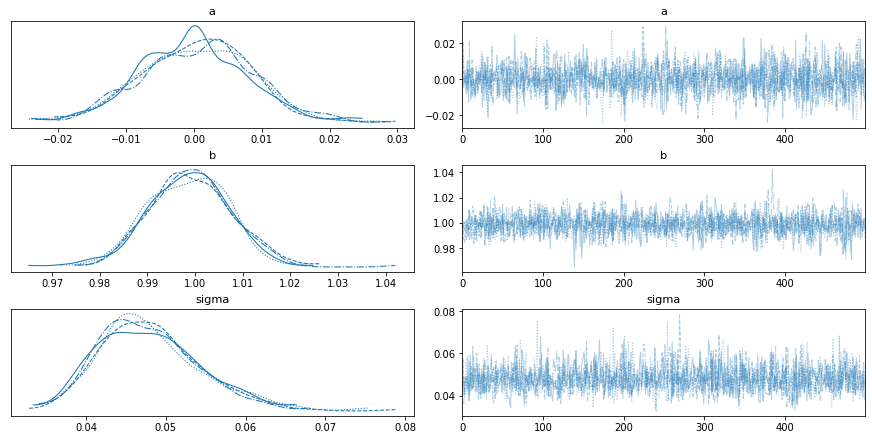

In [31]:
with basic_model:
    az.plot_trace(basic_trace)

In [111]:
error_stacked = error_trace.posterior.stack(draws=("chain", "draw"))
offset_stacked = offset_trace.posterior.stack(draws=("chain", "draw"))

In [112]:
error_stacked['sigma'].mean()

<xarray.DataArray 'sigma' ()>
array(0.05571422)

In [113]:
offset_stacked['sigma'].mean()

<xarray.DataArray 'sigma' ()>
array(0.05151601)

In [ ]:
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    segments = 2
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f)
    c = pm.Normal("c", mu=2.08, sigma=0.3)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    b0 = pm.Uniform('b0', 0, s_obs.min())
    bj = pm.Uniform('bj', s_obs.min(), s_obs.max())

    b = 
    #offset = pm.HalfNormal('offset', sigma=2)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    #s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)

    # Process model
    #mu = a + b * lg_s #worked without offset
    mu = a + b * tt.log(s_obs - b)
    
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)
    #q_log = pm.Normal("q_log",
    #             mu=mu,
    #             sigma=sigma,
    #             observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [11]:
#this works
lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()
slope_u = lg_q_s/lg_s_s
f = 3
offset_max = np.min([s_obs.min()*0.9,6])

error_model = pm.Model()

# assume measurement error
with error_model:
    # Priors
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f)
    c = pm.Normal("c", mu=2.08, sigma=0.3)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s)
    b = pm.Uniform('b', 0, s_obs.min())
    #offset = pm.HalfNormal('offset', sigma=2)
    #q_obs_o = q_obs

    # Observation model
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    #s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)

    # Process model
    #mu = a + b * lg_s #worked without offset
    mu = a + b * tt.log(s_obs - b)
    
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)
    #q_log = pm.Normal("q_log",
    #             mu=mu,
    #             sigma=sigma,
    #             observed=lg_q)
    
    #q_sim = pm.Deterministic('q_sim', tt.exp(y))

In [12]:
with error_model:
    error_trace = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, sigma, c, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


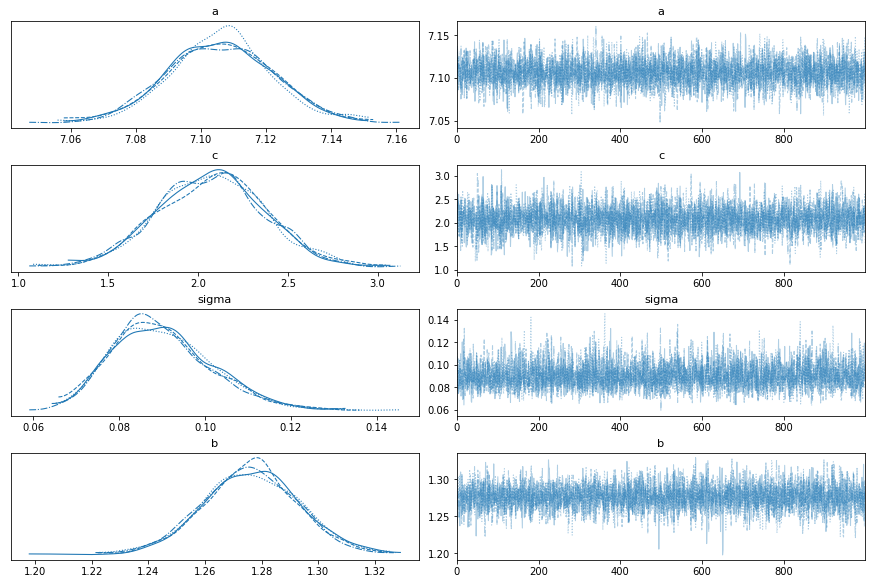

In [10]:
with error_model:
    pm.plot_trace(error_trace)

In [5]:
#read in data
date_format = "%Y-%m-%d %H:%M:%S [UTC%z]"
df = pd.read_csv("../data/green_channel.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format=date_format)

q_obs = df['q'].values
s_obs = df['stage'].values

q_sigma = df['q_sigma'].values
s_sigma = 0.02
#s_sigma = 0.5

n = df['q'].shape[0]

In [ ]:
#SCratch
# single changepoint
from theano import tensor as tt

lg_q = np.log(q_obs)
lg_q_u = lg_q.mean()
lg_q_s = lg_q.std()

lg_s = np.log(s_obs)
lg_s_s = lg_s.std()

f = 3
#offset_max = np.min([s_obs.min()*0.9,6])

stage_model = pm.Model()

# assume measurement error
with stage_model:
    # Priors

    segments = 2

    b0 = pm.Uniform('b0', 0.0, s_obs.min())
    bj = pm.Uniform('bj', s_obs.min(), s_obs.max())
    b = tt.stack([b0, bj])
    
    a = pm.Normal("a", mu=lg_q_u, sigma=lg_q_s*f, shape=segments)
    c = pm.Normal("c", mu=2.08, sigma=0.3, shape=segments)
    sigma = pm.HalfNormal('sigma', sigma=lg_q_s) #XXX make shape 2
    
    #create index
    #i = tt.switch(tt.gt(s_obs, b[1]), 1,0)
    i = pm.math.switch(s_obs >= b[1], 1, 0)
    
    # Observation model (might need to move to begining)
    q_true = q_obs + q_sigma * pm.Normal.dist(0,1).random(size=n)
    #s_true = s_obs + s_sigma * pm.Normal.dist(0,1).random(size=n)
    

    mu = a[i] + c[i] * tt.log(s_obs - b[i])
    y = pm.Lognormal("q", mu=mu, sigma=sigma, observed=q_true)